In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install opencv-python-headless==4.1.2.30
!pip install -U albumentations
!pip install wandb
!pip install torchmetrics
!pip install segmentation_models_pytorch
!pip install torchsummary

In [ ]:
from collections import defaultdict, namedtuple
from itertools import product
import numpy as np
import pandas as pd
import cv2
import os
import wandb
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from torchmetrics import MeanMetric
import torchmetrics.functional as metrics

import segmentation_models_pytorch as sm
from torchsummary import summary

In [ ]:
%env WANDB_SILENT=True
wandb.login()

env: WANDB_SILENT=True


<IPython.core.display.Javascript object>

True

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Read data

In [ ]:
PROJECT_NAME = 'Cracks'

TRAIN_FOLDER = Path('/content/drive/MyDrive/Data/Cracks/train/')
TEST_FOLDER = Path('/content/drive/MyDrive/Data/Cracks/test/')

CHECKPOINTS_FOLDER = Path(f'/content/drive/MyDrive/Checkpoints/{PROJECT_NAME}/')
CHECKPOINTS_FOLDER.mkdir(parents=True, exist_ok=True)

## Parse data


#### Data analyse

In [ ]:
def show_images(
    data,
    show_mask=False,
    show_separate=False,
    titles=None,
    n_max=5,
    shuffle=False,
    size=4,
    n_cols=5,
    cmap='viridis'
):
    if show_mask:
        images, masks = data
    else:
        images = data
    
    to_show = min(len(images), n_max)
    n_rows = to_show // n_cols + 1
    indicies = np.arange(len(images))

    if shuffle:
        np.random.shuffle(indicies)

    if show_separate:
        plt.figure(figsize=(size * n_cols, size * n_rows * 2))
    else:
        plt.figure(figsize=(size * n_cols, size * n_rows))
    
    for i, j in enumerate(indicies[:to_show]):
        
        if images[j].shape[0] == 3:
            image = images[j].permute(1, 2, 0)
        elif images[j].shape[0] == 1:
            image = images[j].squeeze()
        else:
            image = images[j]

        if show_mask and show_separate:
            plt.subplot(n_rows * 2, n_cols, 2*i - i % n_cols + 1)
            plt.imshow(image, cmap=cmap)
            plt.axis('off')
            plt.subplot(n_rows * 2, n_cols, 2*i - i % n_cols + n_cols + 1)
            plt.imshow(masks[j], cmap=cmap)
            plt.axis('off')
        elif show_mask:
            plt.subplot(n_rows, n_cols, i+1)
            plt.imshow(image, cmap=cmap)
            plt.axis('off')
            plt.imshow(masks[j], alpha=0.3, cmap=cmap)
            plt.axis('off')
        else:
            plt.subplot(n_rows, n_cols, i+1)
            plt.imshow(image, cmap=cmap)
            plt.axis('off')
        
        if titles is not None:
            plt.title(titles[j])

#### Dataset

In [ ]:
# Описание своего датасета и наследование от стандартного 'Dataset' из pytorch
# self - стандартный атрибут, он указывается у всех функций в классе
class CracksDataset(Dataset):
    # Инициализация: folder - папка с нашими картинками и масками, в transform передаются ауги
    def __init__(self, folder, transform):
        # Чтение картинок и масок
        images_path = os.path.join(folder, 'images2.pickle')
        masks_path = os.path.join(folder, 'masks2.pickle')
        with open(images_path, 'rb') as f:
            images = pickle.load(f)
        with open(masks_path, 'rb') as f:
            masks = pickle.load(f)
        # Создание списка данных
        self.data = list(zip(images, masks))
        self.transform = transform

    # Получение длины датасета
    def __len__(self):
        return len(self.data)

    # Получение конкретной картинки и маски по индексу
    def __getitem__(self, index):
        image, mask = self.data[index]
        augmentated = self.transform(image=image, mask=mask)
        return augmentated['image'], augmentated['mask']

#### Augmentation & Visalize

In [ ]:
train_transform = A.Compose([
    A.FromFloat(dtype=np.float32, max_value=1.0),
    A.RandomCrop(width=96, height=96),
    # A.OneOf([
    #     A.MotionBlur(p=0.2),
    #     A.MedianBlur(blur_limit=3, p=0.1),
    #     A.Blur(blur_limit=3, p=0.1),
    # ], p=0.2),
    # A.OneOf([
    #     A.OpticalDistortion(p=0.3),
    #     A.GridDistortion(p=0.1),
    # ], p=0.2),
    # A.CoarseDropout(p=0.5, min_holes=5, max_holes=5, min_height=8, min_width=8, max_height=16, max_width=16),
    ToTensorV2()
])

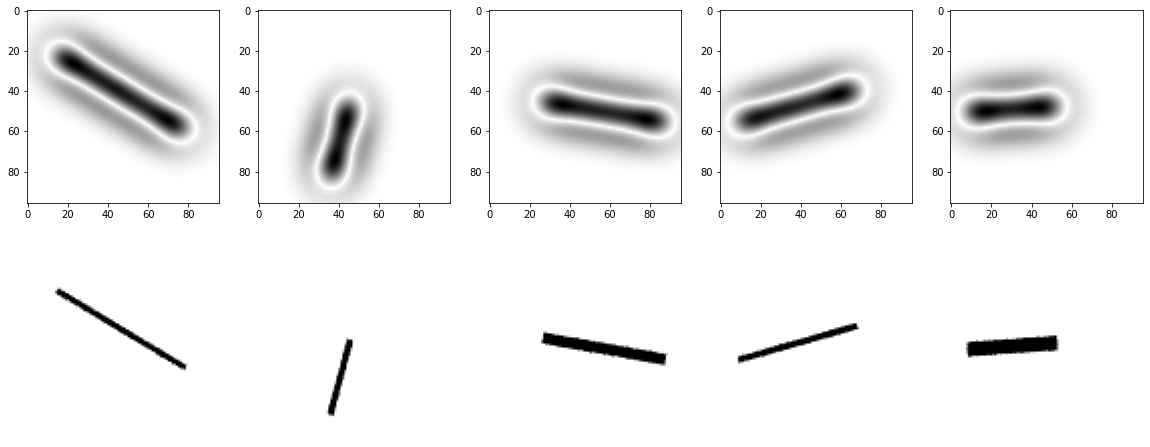

In [ ]:
# Создание датасета
train_dataset = CracksDataset(TRAIN_FOLDER, train_transform)

# Создание DataLoader - для подгрузки данных по батчам
example_loader = DataLoader(dataset=train_dataset, batch_size=5)

# Получить первый батч из DataLoader (просто запомнить)
first_batch = next(iter(example_loader))

show_images(first_batch, show_mask=True, show_separate=True, cmap='binary')

#### Split train/validation

In [ ]:
data_size = len(train_dataset)
val_split_i = int(data_size * 0.2)
data_indices = list(range(data_size))
np.random.shuffle(data_indices)

val_indices = data_indices[:val_split_i]
train_indices = data_indices[val_split_i:]

len(val_indices), len(train_indices)

(30, 120)

## Train

In [ ]:
def train_model(
    train_loader,
    val_loader,
    model,
    criterion,
    metric,
    optimizer,
    scheduler=None,
    epochs=5,
    run_name='main',
    log=False,
    silent_mode=False,
    metric_treshhold=0.0
):
    if log:
        wandb.init(project=PROJECT_NAME)

    loss_meter, metric_meter = MeanMetric(), MeanMetric()
    best_loss, best_metric = float('inf'), float('inf')

    for epoch in tqdm(range(1, epochs + 1), disable=silent_mode):
        # Train
        loss_meter.reset()
        metric_meter.reset()
        model.train()
        for X, y in train_loader:
            X_gpu = X.to(device)
            y_gpu = y.to(device)
            prediction = model(X_gpu)
            loss_value = criterion(prediction, y_gpu)
            metric_value = metric(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            loss_meter.update(loss_value.item())
            metric_meter.update(metric_value.item())
        
        train_loss, train_metric = loss_meter.compute(), metric_meter.compute()
        
        # Validation
        loss_meter.reset()
        metric_meter.reset()
        model.eval()
        with torch.no_grad():
            for X, y in val_loader:
                X_gpu = X.to(device)
                y_gpu = y.to(device)
                prediction = model(X_gpu)
                loss_value = criterion(prediction, y_gpu)
                metric_value = metric(prediction, y_gpu)
                loss_meter.update(loss_value.item())
                metric_meter.update(metric_value.item())
        
        val_loss, val_metric = loss_meter.compute(), metric_meter.compute()

        # Learning rate annealing
        if scheduler is not None:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(train_loss)
            else:
                scheduler.step()

        # Log
        if not silent_mode:
            print(f'epoch: {epoch:<3}', end=' | ') 
            print(f'train_loss: {train_loss:.5f}', end=' | ')
            print(f'train_metric: {train_metric:.3f}', end=' | ')
            print(f'val_loss: {val_loss:.5f}', end=' | ')
            print(f'val_metric: {val_metric:.3f}')
        if log:
            wandb.log({
                'train_loss': train_loss,
                'train_metric': train_metric,
                'val_loss': val_loss,
                'val_metric': val_metric
            }, step=epoch)

        # Saving model checkpoint
        if val_loss < best_loss:
            best_loss = val_loss
            best_metric = val_metric
            torch.save(model, os.path.join(CHECKPOINTS_FOLDER, f'{run_name}.pt'))
        
        # Exiting if metric is low
        if val_metric < metric_treshhold:
            break
    
    if log:
        wandb.finish()

    if not silent_mode:
        print(f'\nbest_loss: {best_loss:.5f}, best_metric: {best_metric:.3f}')
    else:
        return best_loss.item(), best_metric.item()

In [ ]:
def get_best_model(checkpoints_folder, run_name):
    return torch.load(os.path.join(checkpoints_folder, f'{run_name}.pt'))

## Metrics


In [ ]:
class DiceMetric(nn.Module):
    def __init__(self, smooth=1):
        super().__init__()
        self.smooth = 1e-15
    
    def forward(self, inputs, targets):
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        denominator = inputs.sum() + targets.sum() + self.smooth

        return (2.0 * intersection + self.smooth) / denominator

## Model, loss & optimizer

#### Data loaders

In [ ]:
batch_size = data_size // 10

train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_indices)
)

val_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(val_indices)
)

#### Model


In [ ]:
class LastLayer(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return x.sigmoid().squeeze()

In [ ]:
model1 = nn.Sequential(
    sm.Unet(
        encoder_name='resnet18',
        encoder_weights='imagenet',
        in_channels=1,
        classes=1
    ),
    LastLayer()
)
model1.to(device)

criterion = nn.BCEWithLogitsLoss()
metric = DiceMetric()
optimizer = optim.Adam(model1.parameters(), lr=5e-4, weight_decay=1e-2)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

In [ ]:
train_model(train_loader, val_loader, model1, criterion, metric, optimizer, scheduler, epochs=100, run_name='Unet-1', log=True)

  0%|          | 0/100 [00:00<?, ?it/s]

epoch: 1   | train_loss: 0.89981 | train_metric: 0.079 | val_loss: 0.90326 | val_metric: 0.041
epoch: 2   | train_loss: 0.82979 | train_metric: 0.107 | val_loss: 0.84211 | val_metric: 0.042
epoch: 3   | train_loss: 0.78623 | train_metric: 0.138 | val_loss: 0.79038 | val_metric: 0.044
epoch: 4   | train_loss: 0.76129 | train_metric: 0.166 | val_loss: 0.76273 | val_metric: 0.044
epoch: 5   | train_loss: 0.74562 | train_metric: 0.185 | val_loss: 0.74723 | val_metric: 0.043
epoch: 6   | train_loss: 0.73797 | train_metric: 0.212 | val_loss: 0.73554 | val_metric: 0.044
epoch: 7   | train_loss: 0.73221 | train_metric: 0.235 | val_loss: 0.72807 | val_metric: 0.039
epoch: 8   | train_loss: 0.72584 | train_metric: 0.261 | val_loss: 0.72434 | val_metric: 0.047
epoch: 9   | train_loss: 0.72089 | train_metric: 0.287 | val_loss: 0.72059 | val_metric: 0.107
epoch: 10  | train_loss: 0.71781 | train_metric: 0.293 | val_loss: 0.71765 | val_metric: 0.133
epoch: 11  | train_loss: 0.71370 | train_metric: 0

## Predict

In [ ]:
def evaluate_model(dataset, model):

    loader = DataLoader(dataset, batch_size=len(dataset))
    X, y = next(iter(loader))

    model.eval()
    with torch.no_grad():
        X_gpu = X.to(device)
        preds = model(X_gpu)
    
    return X, y, preds.cpu()

In [ ]:
test_dataset = CracksDataset(
    TEST_FOLDER,
    transform=A.Compose([
        A.FromFloat(dtype=np.float32, max_value=1.0),
        A.RandomCrop(width=96, height=96),
        ToTensorV2()
    ])
)

In [ ]:
best_model = get_best_model(CHECKPOINTS_FOLDER, 'Unet-1')
inputs, gt, preds = evaluate_model(test_dataset, best_model)

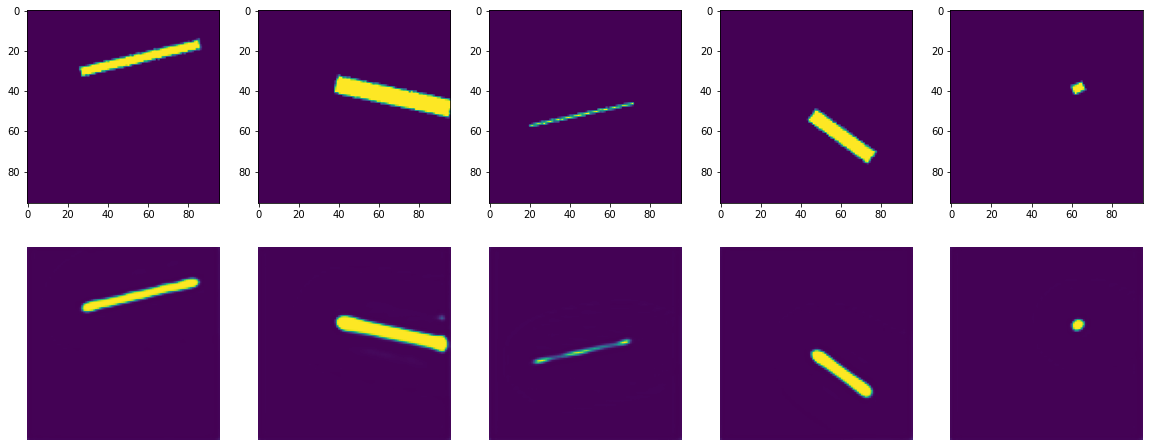

In [ ]:
show_images((gt, preds), show_mask=True, show_separate=True)

In [ ]:
def get_line_points(image):
    points = [None]*4

    for y, x in product(range(image.shape[0]), range(image.shape[1])):
        if image[y][x] > 0.7:
            points[0] = (x, y) if points[0] is None else points[0]
            points[1] = (x, y)
    for x, y in product(range(image.shape[1]), range(image.shape[0])):
        if image[y][x] > 0.7:
            points[2] = (x, y) if points[2] is None else points[2]
            points[3] = (x, y)

    return [(0.0, 0.0) if point is None else point for point in points]

In [ ]:
def get_line_length_and_angle(image):
    (x1, y1), (x2, y2), (x3, y3), (x4, y4) = get_line_points(image)

    d1 = np.sqrt((x1 - x3)**2 + (y1- y3)**2)
    d2 = np.sqrt((x1 - x4)**2 + (y1- y4)**2)
    a1 = np.degrees(np.arctan((y1 - y3) / (x3 - x1 + 1e-15)))
    a2 = np.degrees(np.arctan((y1 - y4) / (x4 - x1 + 1e-15)))

    length = d1 if d1 > d2 else d2
    angle = a1 if d1 > d2 else a2

    return length, angle

((83, 53), (27, 75), 63.89053137985315, 17.300527191945005)

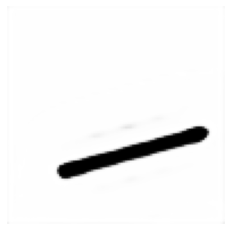

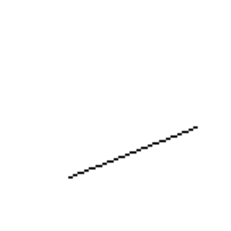

In [ ]:
pred = preds[7]

p1, p2, _, _ = get_line_points(pred)

line_mask = np.zeros_like(pred, dtype=np.float32)
line_mask = cv2.line(line_mask, p1, p2, color=255, thickness=1)

length, angle = get_line_length_and_angle(pred)

show_images([pred], cmap='binary')
show_images([line_mask], cmap='binary')

p1, p2, length, angle

In [ ]:
titles = list()
for pred in preds:
    length, angle = get_line_length_and_angle(pred)
    title = f'angle: {angle:.2f}, length: {length:.2f}'
    titles.append(title)

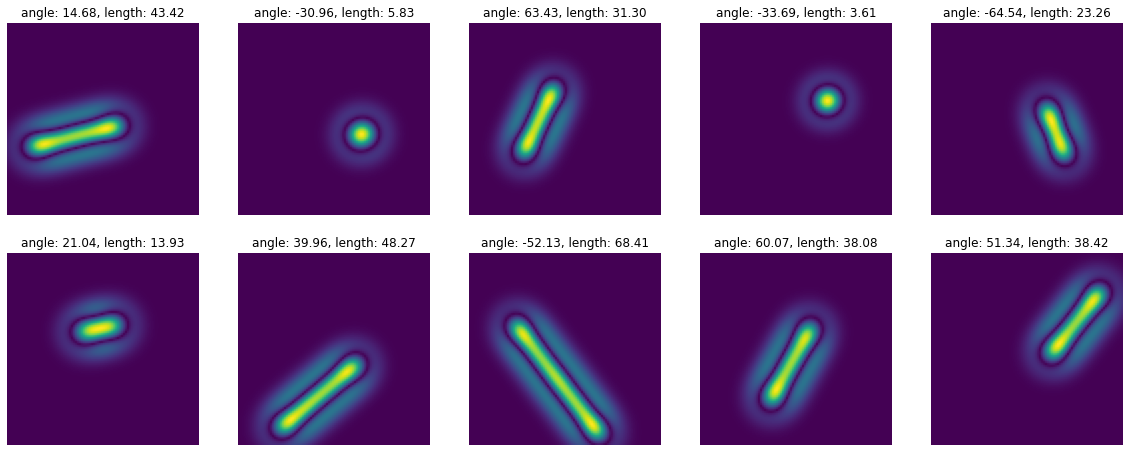

In [ ]:
show_images(inputs, titles=titles, n_max=10, shuffle=True)

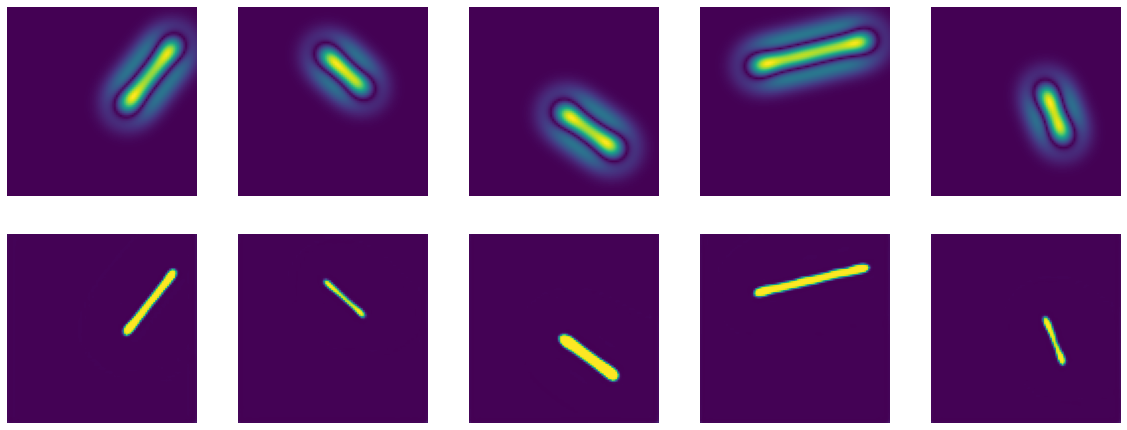

In [ ]:
show_images((inputs, preds), show_mask=True, show_separate=True, shuffle=True)